In [27]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [28]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
exps = ['sim','ser']
rois = ['wm','ventricles']
runs = map(str,range(1,4))

In [29]:
def vector_rejection(a,b):
    return a - (np.dot(a,b)/np.dot(b,b) * b)

#First extract ROIS from noise masks for use in GLM

In [32]:
def extract_roi(in_tuple):
    sub,exp,run,mask = in_tuple
    
    sub_path = home_dir + 'analysis/' + exp + '_4mm/' + sub + '/preproc/run_' + \
    run + '/'

    #make sure to get coregistered preproc data
    preproc_data = home_dir + 'analysis/' + exp + '_4mm/' + sub + '/reg/epi/unsmoothed/run_' \
    + str(run) + '/timeseries_xfm.nii.gz'

    mask_dir = home_dir + 'data/' + sub + '/masks/' 
    out_dir = mask_dir + 'extractions/'
    
    if not os.path.exists(out_dir):
        os.mkdir(mask_dir)

    mask_file = mask_dir + mask + '_' + exp  + '.nii.gz'
    out_f = out_dir + ('').join(map(str,in_tuple))+ '.txt'
    if os.path.exists(out_f):
        os.remove(out_f)

    if os.path.exists(sub_path) and not os.path.exists(out_f):
        meants = ImageMeants(in_file = preproc_data, eig = True, order = 1, 
                             mask = mask_file, out_file = out_f)
        meants.run()


In [33]:
in_tuples = []
for sub in sub_list:
    if sub == 'fd_104':
        for exp in ['ser','sim']:
            for run in runs:
                for mask in rois:
                    in_tuples.append((sub,exp,run,mask))

In [34]:
pool = multiprocessing.Pool(processes = 12)
pool.map(extract_roi,in_tuples)
pool.terminate()
pool.join()

In [36]:
for sub in sub_list:
    for exp in exps:
        noise_rois = {'wm':[],'ventricles':[],'run':[]}
        out_f = home_dir + 'data/' + sub + '/design/noise_regressors_' + exp + '.csv' #out file
        
        for run in runs:
            for n,mask in enumerate(rois):
                
                in_tuple = (sub,exp,run,mask)
                
                ##paths
                sub_path = home_dir + 'analysis/' + exp + '_4mm/' + sub + '/preproc/run_' + \
                run + '/'
                out_dir = home_dir + 'data/' + sub + '/masks/extractions/' 

                #get data
                if os.path.exists(sub_path):
                    data_f = out_dir + ('').join(map(str,in_tuple))+ '.txt'
                    data = np.loadtxt(data_f)
                    noise_rois[mask].extend(data)
                    if n > 0: #only add run once per iteration through all masks
                        noise_rois['run'].extend([run]*len(data))
        
        noise_rois = pd.DataFrame(noise_rois)
        
        #orthogonalize noise regressors to speed up computation
        noise_rois['ventricles'] = vector_rejection(noise_rois['ventricles'],noise_rois['wm'])
        
        ##write output
        noise_rois.to_csv(out_f, header=True,index = False, columns = ['wm','ventricles','run'])

#Next extract tsnr from lyman outputs

In [67]:
all_rois = {'ser':["lOFC_fill_ser", "mOFC_fill_ser","V1_fill_ser","cortex_fill_ser",
                   '','ser_lOFC_mask'],
            'sim':["lOFC_fill_sim", "mOFC_fill_sim","V1_fill_sim","cortex_fill_sim",'sim_vta_mask']}
in_tuples = []
for sub in sub_list:
    for exp in exps:
        for run in runs:
            rois = all_rois[exp]
            for mask in rois:
                in_tuples.append((sub,exp,run,mask))

In [69]:
#extract tsnr of ROIs
def extract_tsnr(in_tuple):
    sub,exp,run,mask,ffx = in_tuple
    tsnr = np.nan
    
    if ffx:        
        tsnr_f = home_dir + 'analysis/' + exp + '_4mm-PEfb/' + sub + \
            '/ffx/epi/smoothed/tsnr.nii.gz'
        if run != '1': #only run once (since fixed effects accross runs)
            return (sub,exp,run,mask,tsnr) 
    else:
        tsnr_f = home_dir + 'analysis/' + exp + '_4mm-PEfb/' + sub + \
            '/model/smoothed/run_' + str(run) + '/tsnr.nii.gz'

    if os.path.exists(tsnr_f):
        
        mask_dir = home_dir + 'data/' + sub + '/masks/' 
        mask_file = mask_dir + mask + '.nii.gz'
        if mask == 'ser_vta_mask':
            mask_file = mask_dir + '/vta/'+ mask + '.nii.gz'
        if mask == 'ser_lOFC_mask':
            mask_file = mask_dir + '/decoding/'+ mask + '.nii.gz'        

        stats = ImageStats(in_file = tsnr_f, op_string = '-k %s -M', mask_file = mask_file)
        out = stats.run()
        tsnr = out.outputs.out_stat
    
    return (sub,exp,run,mask,tsnr)

In [218]:
def roi_sizes_simser():
    roi_sizes = pd.DataFrame(columns=['lOFC','mOFC','V1'], index=sub_list, dtype=float)
    mask_template = os.path.join(home_dir, "data/%s/masks/%s.nii.gz")
    for exp in exps:
        for subj in sub_list:
            for roi in all_rois[exp]:
                mask = home_dir + 'data/' + subj + '/masks/' + roi + '.nii.gz'
                vox_count = nib.load(mask).get_data().sum()
                roi_sizes.loc[subj,roi.split('_')[0]] = vox_count
    return roi_sizes
roi_sizes = roi_sizes_simser()
roi_sizes.describe().loc[["mean", "std"]].astype(int)

,lOFC,mOFC,V1,cortex
mean,5947,4028,6385,152909
std,450,328,814,14915


/home/iballard/.local/lib/python2.7/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


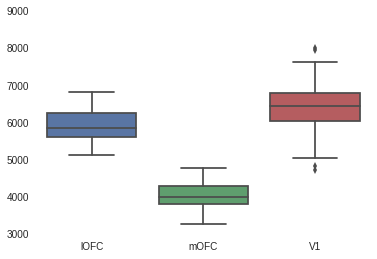

In [167]:
#check to see if any ROIs are drastically too small
roi = 'mOFC'
thresh = roi_sizes[roi].mean() - 2*roi_sizes[roi].std()
roi_sizes[roi_sizes[roi] < thresh]
sns.boxplot(roi_sizes)

In [166]:
ffx = True
in_tuples = []
for sub in sub_list:
    for exp in ['ser']:
        for run in runs:
            rois = all_rois[exp]
            for mask in rois:
                in_tuples.append((sub,exp,run,mask,ffx))
# pool = multiprocessing.Pool(processes = 25)
# out = pool.map(extract_tsnr,in_tuples)
# pool.terminate()
# pool.join()

In [167]:
tsnr_df = {'roi':[],'tsnr':[],'run':[],'sub':[],'exp':[]}
for o in out:
    sub,exp,run,mask,tsnr = o

    if ffx:
        out_f = 'tsnr_ffx.csv'
        if run=='1':
            tsnr_df['roi'].append(mask.split('_')[0] + mask.split('_')[1])
            tsnr_df['sub'].append(sub)
            tsnr_df['run'].append(run)
            tsnr_df['exp'].append(exp)
            tsnr_df['tsnr'].append(tsnr)
    else:
        out_f = 'tsnr_runs.csv'

        tsnr_df['roi'].append(mask.split('_')[0] + mask.split('_')[1])
        tsnr_df['sub'].append(sub)
        tsnr_df['run'].append(run)
        tsnr_df['exp'].append(exp)
        tsnr_df['tsnr'].append(tsnr)
tsnr_df = pd.DataFrame(tsnr_df)
tsnr_df.to_csv(home_dir + '/' + out_f)

     exp     roi run     sub       tsnr
40   ser  servta   1  fd_112  55.141859
46   ser  servta   1  fd_113  55.774371
82   ser  servta   1  fd_122  56.578112
136  ser  servta   1  fd_133  56.474236
142  ser  servta   1  fd_135  55.642643
178  ser  servta   1  fd_144  56.789889


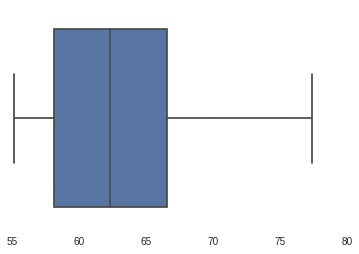

In [172]:
# tsnr_df = pd.read_csv(home_dir + '/tsnr_ffx.csv')
tsnr = tsnr_df[tsnr_df['roi']=='servta']['tsnr'].values
thresh = np.nanmean(tsnr) - 1* np.nanstd(tsnr)
a = tsnr_df[tsnr_df['tsnr'] < thresh]
print a[a['roi']=='servta']
sns.boxplot(tsnr_df[tsnr_df['roi']=='servta']['tsnr'].values)

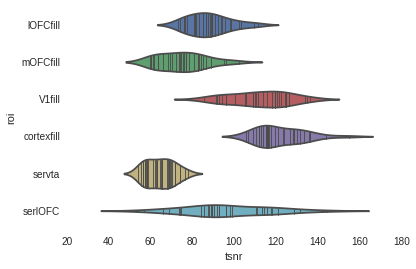

In [100]:
# sns.violinplot(x='tsnr',y='roi',hue='exp',data=tsnr_df,split=True,inner = 'stick')
sns.violinplot(x='tsnr',y='roi',data=tsnr_df,split=True,inner = 'stick')

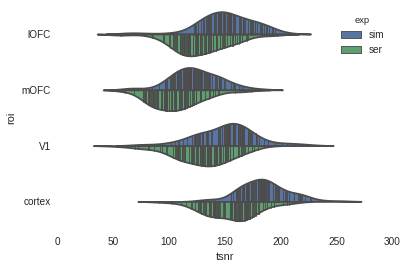

In [240]:
sns.violinplot(x='tsnr',y='roi',hue='exp',data=tsnr_df,split=True,inner = 'stick')

In [288]:
#find dubious runs by looking for tsnr appreciably lower than V1
# thresh = tsnr_df[tsnr_df['roi']=='V1']['tsnr'].mean() - \
#     2*tsnr_df[tsnr_df['roi']=='V1']['tsnr'].std()

# low_tsnr = tsnr_df[tsnr_df['tsnr']<thresh]
# low_tsnr = low_tsnr[low_tsnr['roi']!='V1'].sort(['exp','sub','run'])
# low_tsnr = low_tsnr.drop(['tsnr','roi'],1)
# low_tsnr = low_tsnr.drop_duplicates()
# low_tsnr = low_tsnr.reset_index()
# low_tsnr = low_tsnr.drop(['index'],1)
# low_tsnr


cortex = tsnr_df[tsnr_df['roi']=='cortex']
# cortex = cortex[cortex['sub'] != 'fd_146']
# cortex = cortex[cortex['sub'] != 'fd_143']
iqr = cortex.quantile(.75) - cortex.quantile(.25)
thresh =  cortex.quantile(.25) - 1 * iqr
thresh = thresh.values[0]

# thresh = cortex['tsnr'].mean() - 2*cortex['tsnr'].std()
print cortex[cortex['tsnr'] < thresh]

     exp     roi run     sub        tsnr
263  ser  cortex   3  fd_117  122.829293
287  ser  cortex   3  fd_118  115.431145
375  ser  cortex   1  fd_124  102.336310
599  ser  cortex   3  fd_136  119.295840
715  ser  cortex   2  fd_144  120.830062
739  ser  cortex   2  fd_146  110.267971
743  ser  cortex   3  fd_146   90.953050


In [205]:
#find dubious runs by looking for tsnr appreciably lower than V1
thresh = tsnr_df[tsnr_df['roi']=='V1']['tsnr'].mean() - \
    2.5*tsnr_df[tsnr_df['roi']=='V1']['tsnr'].std()

low_tsnr = tsnr_df[tsnr_df['tsnr']<thresh]
low_tsnr = low_tsnr.sort(['sub'])
# low_tsnr = low_tsnr[low_tsnr['roi']!='V1'].sort(['exp','sub','run'])
# low_tsnr = low_tsnr.drop(['tsnr','roi'],1)
# low_tsnr = low_tsnr.drop_duplicates()
# low_tsnr = low_tsnr.reset_index()
# low_tsnr = low_tsnr.drop(['index'],1)
low_tsnr

,exp,roi,run,sub,tsnr
175,sim,mOFC,1,fd_143,110.331159
178,ser,mOFC,1,fd_143,108.349422
191,ser,V1,1,fd_146,106.566963


(34, 91, 109, 91)
